In [1]:
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import os
import itertools
import socket
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import time


import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from IPython.display import display
from IPython.display import clear_output

In [2]:
print(os.getcwd())

C:\Users\zchodan\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums


In [3]:
# Declare important variables
train_path = 'train.csv'
solve_path = 'test.csv'
target_variable = 'Premium Amount'
SEED = 69
skip_hypertuning = True

In [4]:
def load_dataframes(path1: str, path2: str, format1: str = "csv", format2: str = "csv") -> tuple:

    if socket.gethostname() == 'zchodani-p-l01':
        file_directory = r"C:\Users\zchodaniecky\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums"
    elif socket.gethostname() == 'FTILC3VBil7BwCe':
        file_directory = r"C:\Users\zchodan\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums"
    else:
        file_directory = r"C:\Users\zanec\OneDrive\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums"
         
    os.chdir(file_directory)

    loaders = {
        "csv": pd.read_csv,
        "excel": pd.read_excel,
        "json": pd.read_json,
    }

    if format1 not in loaders or format2 not in loaders:
        raise ValueError("Unsupported format. Supported formats: 'csv', 'excel', 'json'.")

    # Load the dataframes using appropriate loaders
    df1 = loaders[format1](path1)
    df2 = loaders[format2](path2)

    return df1, df2

In [5]:
df_train, df_solve = load_dataframes(train_path,solve_path)

In [6]:
df_train_id = df_train['id']
df_train = df_train.drop('id',axis=1)

df_solve_id = df_solve['id']
df_solve = df_solve.drop('id',axis=1)

In [7]:
from typing import Tuple

def plot_kde_grid(df: pd.DataFrame, n_cols: int = 4, figsize: Tuple[int, int] = (12,8)) -> None:
    """
    Plots KDE for all numeric columns in the dataframe in a grid layout.
    
    Parameters:
        df (pd.DataFrame): DataFrame with numeric columns to plot.
        n_cols (int): Number of columns in the grid (default is 3).
        figsize (tuple): Size of the entire figure (default is (12, 8)).
    
    Returns:
        None
    """
    # Get numeric columns
    numeric_cols = df.select_dtypes(include='number').columns
    
    # Set up grid size
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))  # Number of rows based on the number of features
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize))  # Adjust figure size
    axes = axes.flatten()  # Flatten to easily iterate
    
    # Plot each numeric column
    for i, col in enumerate(numeric_cols):
        sns.kdeplot(data=df, x=col, fill=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
    
    # Hide any unused subplots
    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [8]:
# Smoothed distributions of X values
#plot_kde_grid(df_train,n_cols=4,figsize=(12,8))

In [9]:
# Smoothed distributions of X values for real data
#plot_kde_grid(df_solve,n_cols=4,figsize=(9,6))

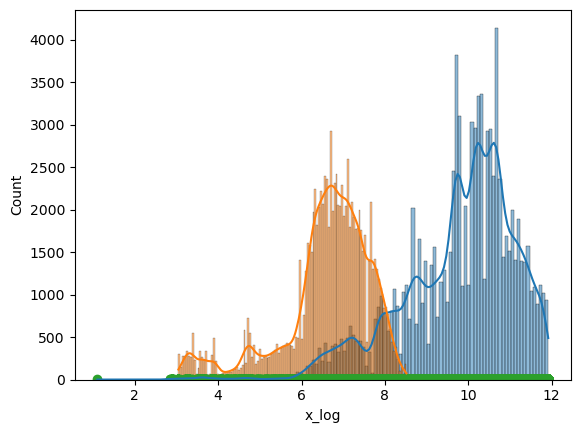

In [10]:
""" Annual Income and Premium Amount look to have some sort of correlation
    and both are right skew, lets look close
"""
df_hist = pd.DataFrame()
df_hist['x_log'] = np.log(df_train['Annual Income'] + 1)   # Add 1 to avoid log(0)
df_hist['y_log'] = np.log(df_train['Premium Amount'] + 1)  # Add 1 to avoid log(0)

# Plot histograms to check for skewness
sns.histplot(df_hist['x_log'], kde=True)
sns.histplot(df_hist['y_log'], kde=True)

# Scatter plot to check correlation between x and y
plt.scatter(df_hist['x_log'], df_hist['y_log'])
plt.show()

In [11]:
def describe_dataframe(df_to_use: pd.DataFrame, name: str = 'DataFrame', nrows: int = 3, plots: bool = False, info: bool = True) -> None:
    '''
    Function to describe the DataFrame with summary statistics, missing value count,
    unique value count, and duplicate count. It also displays plots for missing and unique values.
    
    Parameters:
    - df: The DataFrame to describe.
    - name: The name to display in the summary (default is 'DataFrame').
    - nrows: The number of rows to display from the top and bottom (default is 3).
    - plots: Whether to display bar plots for missing and unique values (default is False).
    - info: Whether to display the styled DataFrame (default is True).
    '''

    df = df_to_use.copy()
    
    # Create summary DataFrame
    inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    
    # Missing values
    df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})
    df_missing['pct_missing'] = (df_missing['missing'] / df.shape[0]) * 100
    
    # Unique values
    df_unique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index':'column', 0:'unique'})
    
    # Combine summary information
    inf['missing'] = df_missing['missing']
    inf['pct_missing'] = df_missing['pct_missing']
    inf['unique'] = df_unique['unique']
    inf['duplicate'] = df.duplicated().sum()

    # Descriptive statistics
    desc = pd.DataFrame(df.describe(include='all').transpose())
    if 'min' in desc.columns.tolist():
        inf['min'] = desc['min'].values
        inf['max'] = desc['max'].values
        inf['avg'] = desc['mean'].values
        inf['std dev'] = desc['std'].values
    if 'top' in desc.columns.tolist():
        inf['top value'] = desc['top'].values
        inf['Freq'] = desc['freq'].values 
    
    # Display styled DataFrame
    if info:
        display(inf.style.background_gradient(subset=['missing','pct_missing'], cmap='Reds').background_gradient(subset='unique', cmap='Greens'))

    if nrows != 0 :
        # Display top and bottom nrows of the DataFrame
        print(f"\n---------- {name} Overview ----------:")
        print(f"{name} has {df.shape[0]} rows and {df.shape[1]} columns\n")
        display(df.head(nrows))
        display(df.tail(nrows))
    
    # Plot missing values if any
    if plots and df_missing['missing'].sum() > 0:
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_missing[df_missing['missing'] > 0], x='column', y='missing', ax=ax)
        ax.set_title(f'{name} missing Values') 
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()
    
        # Plot unique values
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_unique[df_unique['unique'] > 0], x='column', y='unique', ax=ax)
        ax.set_title(f'{name} Unique Values')
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()

In [12]:
def get_num_cols(df: pd.DataFrame) -> None:
    num_cols = df.select_dtypes(include=[np.float64, np.int64, np.int32]).columns.to_list()
    
    return num_cols

In [13]:
def get_cat_cols(df: pd.DataFrame) -> None:
    cat_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()  

    return cat_cols

In [14]:
def clean_dataframe(df_to_use: pd.DataFrame, impute_num_cols: bool = True, fill_cat_cols: bool = True) -> None:
    df = df_to_use.copy()
    
    # inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    # df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})  
    # # Merge the two DataFrames on 'column'
    # inf['missing'] = df_missing['missing'] 
    # Filter columns where the type is either 'float' or 'int' and there are missing values
    numeric_cols = df.select_dtypes(include=[np.float64, np.int64, np.int32]).columns
    missing_numeric_columns = [
        col for col in numeric_cols if df[col].isnull().sum() > 0
    ]

    # Fill nulls in numeric columns with the median
    if impute_num_cols:       
        for column in missing_numeric_columns:
            mdn = df[column].median()
            df[column] = df[column].fillna(mdn)

    
    # Get category columns
    if fill_cat_cols:
        cat_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()  
        # Fill missing values in object columns
        for column in cat_cols:
            df[column] = df[column].fillna('Unknown')
    
    return df

In [15]:
def transform_dataframe(df_to_use: pd.DataFrame, frequency_encode_cats: bool = True) -> None:
    
    df = df_to_use.copy()
    
    # Transform Date Fields
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Year'] = df['Policy Start Date'].dt.year
    df['Day'] = df['Policy Start Date'].dt.day
    df['Month'] = df['Policy Start Date'].dt.month
    df['Month Name'] = df['Policy Start Date'].dt.month_name()
    df['Day of Week'] = df['Policy Start Date'].dt.day_name()
    df['Year Sin'] = np.sin(2 * np.pi * df['Year'])
    df['Month Sin'] = np.sin(2 * np.pi * df['Month'] / 12) 
    df['Month Cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day Sin'] = np.sin(2 * np.pi * df['Day'] / 31)  
    df['Day Cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    
    df = df.drop('Policy Start Date', axis=1)
    
    
       # Creating Ratio variables, as well as categorizing continuous ones
    df['Claims v Duration'] = df['Previous Claims'] / df['Insurance Duration']
    df['Cat Credit Score'] = df['Credit Score'].copy()
    df['Int Credit Score'] = df['Credit Score'].apply(lambda x: int(x) if pd.notna(x) else x)
    df['Int Annual Income'] = df['Annual Income'].apply(lambda x: int(x) if pd.notna(x) else x)
    
    

    # List of columns to encode
    columns_to_encode = [
        'Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
        'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
        'Property Type','Month Name','Day of Week'
    ]

    if frequency_encode_cats:
        cat_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()  
        
        # Apply frequency encoding to Categories
        for col in cat_cols:
            # Get the column names before encoding
            existing_columns = set(df.columns)
            
            freq_encoding = df[col].value_counts()  # Count occurrences
    
            df[f'{col}_Freq'] = df[col].map(freq_encoding).astype('int32')  # Map frequencies to the original data
            
            
        df = df.drop(columns=cat_cols, axis=1)
    
    return df

In [16]:
describe_dataframe(df_train, name='Insurance Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,min,max,avg,std dev,top value,Freq
0,Age,float64,1540,1.540000,47,0,18.000000,64.000000,41.176000,13.549630,nan,nan
1,Gender,object,0,0.000000,2,0,nan,nan,nan,nan,Male,50407
2,Annual Income,float64,3792,3.792000,33760,0,2.000000,149996.000000,32761.461750,32179.156965,nan,nan
3,Marital Status,object,1553,1.553000,3,0,nan,nan,nan,nan,Single,33251
4,Number of Dependents,float64,9105,9.105000,5,0,0.000000,4.000000,2.007976,1.415089,nan,nan
5,Education Level,object,0,0.000000,4,0,nan,nan,nan,nan,Bachelor's,25374
6,Occupation,object,29818,29.818000,3,0,nan,nan,nan,nan,Employed,23568
7,Health Score,float64,5968,5.968000,76632,0,2.053458,58.886035,25.609103,12.195576,nan,nan
8,Location,object,0,0.000000,3,0,nan,nan,nan,nan,Suburban,33628
9,Policy Type,object,0,0.000000,3,0,nan,nan,nan,nan,Premium,33844


In [17]:
df_train_cleaned = clean_dataframe(df_train, fill_cat_cols=True)
df_solve_cleaned = clean_dataframe(df_solve, fill_cat_cols=True)

In [18]:
describe_dataframe(df_train_cleaned, name='Insurance Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,min,max,avg,std dev,top value,Freq
0,Age,float64,0,0.000000,47,0,18.000000,64.000000,41.173290,13.444909,nan,nan
1,Gender,object,0,0.000000,2,0,nan,nan,nan,nan,Male,50407
2,Annual Income,float64,0,0.000000,33760,0,2.000000,149996.000000,32424.942160,31608.620253,nan,nan
3,Marital Status,object,0,0.000000,4,0,nan,nan,nan,nan,Single,33251
4,Number of Dependents,float64,0,0.000000,5,0,0.000000,4.000000,2.007250,1.349131,nan,nan
5,Education Level,object,0,0.000000,4,0,nan,nan,nan,nan,Bachelor's,25374
6,Occupation,object,0,0.000000,4,0,nan,nan,nan,nan,Unknown,29818
7,Health Score,float64,0,0.000000,76633,0,2.053458,58.886035,25.548309,11.828520,nan,nan
8,Location,object,0,0.000000,3,0,nan,nan,nan,nan,Suburban,33628
9,Policy Type,object,0,0.000000,3,0,nan,nan,nan,nan,Premium,33844


In [19]:
df_train_prepared = transform_dataframe(df_train_cleaned, frequency_encode_cats= False)
df_solve_prepared = transform_dataframe(df_solve_cleaned, frequency_encode_cats= False)

In [20]:
describe_dataframe(df_train_prepared, name='Insurance Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,min,max,avg,std dev,top value,Freq
0,Age,float64,0,0.000000,47,0,18.000000,64.000000,41.173290,13.444909,nan,nan
1,Gender,object,0,0.000000,2,0,nan,nan,nan,nan,Male,50407
2,Annual Income,float64,0,0.000000,33760,0,2.000000,149996.000000,32424.942160,31608.620253,nan,nan
3,Marital Status,object,0,0.000000,4,0,nan,nan,nan,nan,Single,33251
4,Number of Dependents,float64,0,0.000000,5,0,0.000000,4.000000,2.007250,1.349131,nan,nan
5,Education Level,object,0,0.000000,4,0,nan,nan,nan,nan,Bachelor's,25374
6,Occupation,object,0,0.000000,4,0,nan,nan,nan,nan,Unknown,29818
7,Health Score,float64,0,0.000000,76633,0,2.053458,58.886035,25.548309,11.828520,nan,nan
8,Location,object,0,0.000000,3,0,nan,nan,nan,nan,Suburban,33628
9,Policy Type,object,0,0.000000,3,0,nan,nan,nan,nan,Premium,33844


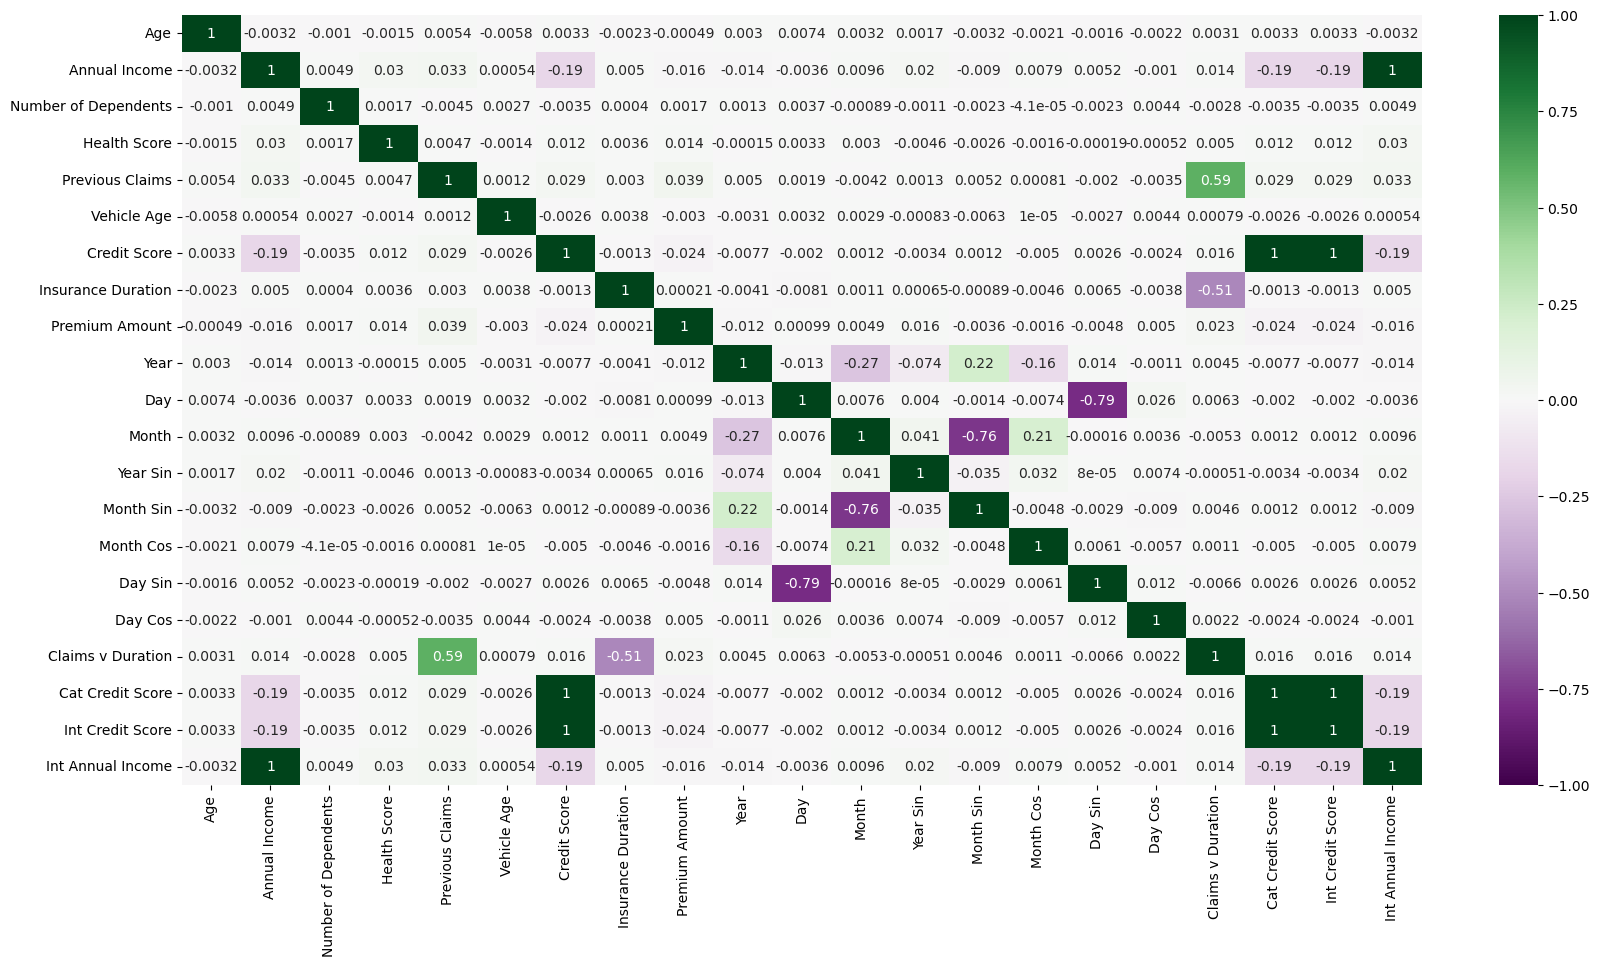

In [21]:

num_cols = get_num_cols(df_train_prepared)

plt.figure(figsize=(20,10))
sns.heatmap(df_train_prepared[num_cols].corr(),
            vmin=-1,
            vmax=1,
            center=0,
            annot=True,
            cmap='PRGn')
plt.show()

In [22]:
from sklearn.model_selection import train_test_split

# Split into 80% training data and 20% testing data

X = df_train_prepared.drop('Premium Amount', axis=1)
y = df_train_prepared['Premium Amount'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)


y_log_train = np.log1p(y_train)
y_log_test = np.log1p(y_test)

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

def pipeline_fit(train_df: pd.DataFrame, cat_encoder: str = 'None'):
    
    # Define a custom transformer for frequency encoding
    class FrequencyEncoder(BaseEstimator, TransformerMixin):
        def __init__(self, columns):
            self.columns = columns

        def fit(self, X, y=None):
            # Calculate the frequency for each category in the columns
            self.freq_dict = {}
            for col in self.columns:
                # Percentage-Based frequency
                self.freq_dict[col] = X[col].value_counts() / len(X)
            return self

        def transform(self, X):
            X_copy = X.copy()
            # Apply frequency encoding based on training set frequencies
            for col in self.columns:
                X_copy[col] = X_copy[col].map(self.freq_dict[col]).fillna(0)
            return X_copy

    # Identify numeric and categorical columns
    num_cols = get_num_cols(train_df)
    cat_cols = get_cat_cols(train_df)

    # Define a ColumnTransformer based on the specified encoding type
    if cat_encoder == 'OneHotEncoder':
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), num_cols),
                ('cat', OneHotEncoder(), cat_cols)
            ],
            remainder='passthrough'
        )
    elif cat_encoder == 'FrequencyEncoder':
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), num_cols),
                ('cat', FrequencyEncoder(columns=cat_cols), cat_cols)
            ],
            remainder='passthrough'
        )
    elif cat_encoder == 'None':
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), num_cols),
            ],
            remainder='passthrough'
        )
    else:
        raise ValueError("cat_encoder must be 'OneHotEncoder', 'FrequencyEncoder', or 'None'.")

    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor)
    ])

    # Fit and transform the train data
    X_train_prepared = pipeline.fit_transform(train_df)

    # Extract column names for the transformed DataFrame
    if cat_encoder == 'OneHotEncoder':
        num_feature_names = num_cols  # Numeric features retain their original names
        cat_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols)
        transformed_columns = list(num_feature_names) + list(cat_feature_names)
    elif cat_encoder == 'FrequencyEncoder' or cat_encoder == 'None':
        transformed_columns = num_cols + cat_cols

    # Convert the output to a DataFrame
    X_train_prepared_df = pd.DataFrame(X_train_prepared, columns=transformed_columns)

    return X_train_prepared, X_train_prepared_df, pipeline


def pipeline_transform(test_df: pd.DataFrame, pipeline: Pipeline, cat_encoder: str = 'None'):
    # Transform the test data using the provided pipeline
    X_test_transformed = pipeline.transform(test_df)

    # Extract column names for the transformed DataFrame
    num_cols = get_num_cols(test_df)
    cat_cols = get_cat_cols(test_df)

    if cat_encoder == 'OneHotEncoder':
        num_feature_names = num_cols  # Numeric features retain their original names
        cat_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols)
        transformed_columns = list(num_feature_names) + list(cat_feature_names)
    elif cat_encoder == 'FrequencyEncoder' or cat_encoder == 'None':
        transformed_columns = num_cols + cat_cols

    # Convert the output to a DataFrame
    X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_columns)

    return X_test_transformed, X_test_transformed_df




In [24]:
# Fit the Pipeline
X_train_prepared, X_train_prepared_df, pipeline = pipeline_fit(X_train, cat_encoder = 'None')
# Transform using the Pipeline
X_test_prepared, X_test_prepared_df = pipeline_transform(X_test, pipeline, cat_encoder = 'None')

In [25]:
from keras import backend as K
from sklearn.metrics import mean_squared_log_error

#Define a custom RMSLE metric
def rmsle(y_true, y_pred):  
    # To avoid log(0), clip values to a small positive constant (epsilon)
    epsilon = tf.keras.backend.epsilon()

    # Apply log transformation
    #y_true_log = tf.math.log1p(y_true)  # Log-transform the true values
    #y_pred_log = tf.math.log1p(y_pred)  # Log-transform the clipped predicted values
    
    # RMSLE formula
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [26]:
from tensorflow import keras
from tensorflow.keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [27]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

# Parameter grid
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.1, 0.01],
    'depth': [5, 6, 7]
}


category_columns = [
        'Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
        'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
        'Property Type','Month Name','Day of Week'
        ]
category_indicies = [X.columns.get_loc(col) for col in category_columns]


# Leave some cores available
available_cores = os.cpu_count()
n_cores = max(1, available_cores - 4)  # Leave 2 cores free


cat_boost = CatBoostRegressor(random_state=SEED)

if skip_hypertuning:

    best_params = {'depth': 7, 'iterations': 500, 'learning_rate': 0.1}

else:
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=cat_boost,
        param_grid=param_grid,
        scoring="neg_mean_squared_error",  # Use RMSE as the evaluation metric
        cv=3,  # 3-fold cross-validation
        verbose=1,  # Output progress messages
        n_jobs=n_cores
    )
    
    grid_search.fit(X_train_prepared_df, y_log_train,cat_features = category_columns)
    
    best_params = grid_search.best_params_
    best_rmse = (-grid_search.best_score_)**0.5
    
    print("Best parameters:",best_params)
    print("Best RMSE:", best_rmse)

    # Calculate elapsed time in minutes
    elapsed_time_minutes = (end_time - start_time) / 60
    print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

In [28]:
# depth = 7   iterations = 500   learning rate = 0.1
# RMSE = 1.0482845368144484

In [29]:


# Initialize the CatBoost
cat_boost = CatBoostRegressor(
    **best_params,
    verbose=100,
    cat_features=category_columns,
    eval_metric='RMSE',
    random_state=SEED
)

# Train the model
cat_boost.fit(
    X_train_prepared_df, 
    y_log_train, 
    eval_set=[(X_test_prepared_df, y_log_test)]
)

0:	learn: 1.0862201	test: 1.0918841	best: 1.0918841 (0)	total: 274ms	remaining: 2m 16s
100:	learn: 1.0421182	test: 1.0577304	best: 1.0577266 (98)	total: 10.2s	remaining: 40.2s
200:	learn: 1.0303925	test: 1.0542177	best: 1.0542177 (200)	total: 20.6s	remaining: 30.6s
300:	learn: 1.0206717	test: 1.0541630	best: 1.0537276 (224)	total: 34s	remaining: 22.5s
400:	learn: 1.0106170	test: 1.0546890	best: 1.0537276 (224)	total: 48s	remaining: 11.9s
499:	learn: 1.0015229	test: 1.0552192	best: 1.0537276 (224)	total: 1m 3s	remaining: 0us

bestTest = 1.053727635
bestIteration = 224

Shrink model to first 225 iterations.


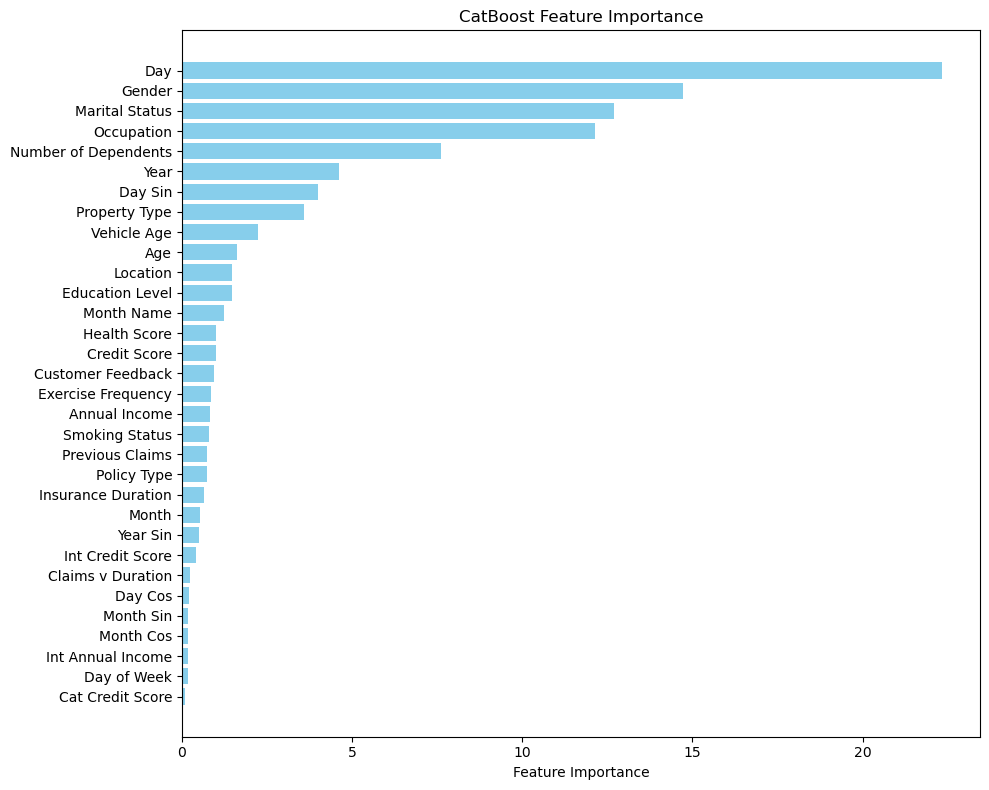

In [30]:
# Plot feature importance
import matplotlib.pyplot as plt
import numpy as np

# Ensure feature names are available
feature_names = X.columns if hasattr(X, 'columns') else np.arange(len(feature_importances))

# Get feature importances
feature_importances = cat_boost.get_feature_importance()

# Sort features by importance
sorted_indices = np.argsort(feature_importances)
sorted_features = np.array(feature_names)[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_importances, color="skyblue")
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.tight_layout()
plt.show()

In [31]:
# Predict on test set
y_test_pred = cat_boost.predict(X_test_prepared_df)

<Axes: >

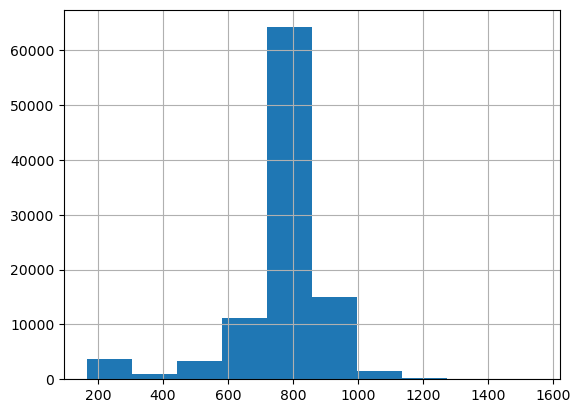

In [32]:
# Create final predictions
df_solve_cleaned = clean_dataframe(df_solve)
df_solve_prepared = transform_dataframe(df_solve_cleaned, frequency_encode_cats = False)
X_solve_prepared= pipeline.transform(df_solve_prepared)


y_log_solve = cat_boost.predict(X_solve_prepared)

y_solve = np.expm1(y_log_solve)  # Inverse of log1p (to get the original scale)

df_y_solve = pd.DataFrame(y_solve, columns=['Premium Amount'])
df_final = pd.merge(df_solve_id, df_y_solve, left_index=True, right_index=True, how='inner')
df_final.to_csv('Predictions_CatBoost.csv', index=False)

df_final['Premium Amount'].hist()